# Deciphering a Seasonal Cycle
By Sage Lichtenwalner - March 24, 2020

In this notebook, we will first create a dummy dataset that includes:
* a simple seasonal cycle (generated using the cosine function), 
* a multi-year trend, 
* and random noise.  

Then, we will use this dataset to demonstrate how one can pull out (that is to say, model) a linear trend and seasonal cycle.

Modeling seasonal cycles and trends is a fundamental part of data analysis, in oceanography or many other fields.  If you have multiple years of data, and that data varies on a regularly recurring cycle (annually, seasonally, monthly, daily or any other period), knowing how to model those cycles is important for understanding the processes that affect the measured data and ultimately making forecasts.

Note, this is a simple example.  There are more robust and comprehensive libraries one can use for more robust time series analysis (including [statsmodel](https://www.statsmodels.org/stable/tsa.html) and [Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api)).

In [0]:
# Notebook setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# This makes the plots prettier
import seaborn as sns
sns.set()

# This removes an annoying warning
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## 1. Creating a Dummy Seasonal Dataset

In [0]:
# Setup a 5-year timeseries dataset
df = pd.DataFrame(index=pd.date_range('2015-01-01','2020-01-01'))

In [0]:
# Use the cosine function to calculate an annual seasonal cycle 
mean = 5
offset = 10
df['y1'] = np.cos(df.index.dayofyear/365*2*np.pi - np.pi)*mean + offset

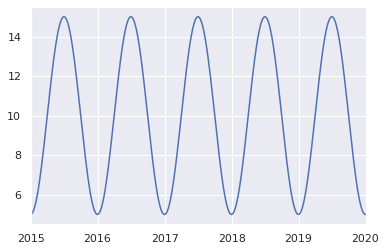

In [4]:
df['y1'].plot();

In [0]:
# Add a trend to the signal
trend = 5 # Increaes over full range
df['y2'] = df['y1'] + trend * (df.index - df.index[0])/np.timedelta64(5,'Y')

# This is an alternative approach
# df['y2'] = df['y1'] + trend*np.arange(0,df.shape[0])/df.shape[0] 

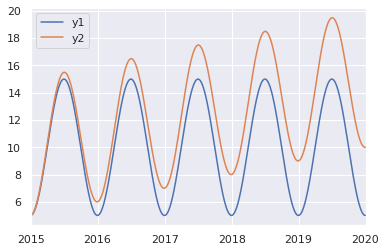

In [6]:
df.plot();

In [0]:
# Finally, let's add some random noise
noise_mean = 0
noise_var = 2
df['y3'] = df['y2'] + np.random.normal(noise_mean, noise_var, df.shape[0])

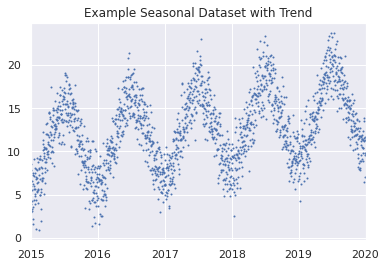

In [8]:
df['y3'].plot(marker='.',markersize=2,linestyle='');
plt.title('Example Seasonal Dataset with Trend');

## 2. Detrending Data
Now that we have an example dataset, let's reverse the process with some good old-fashioned data analysis techniques.

One of the most common first steps is to detrend your dataset.  This removes large-scale long-term changes that may limit the effectiveness other analysis techniques.

But your first question should be, is there a noticeable trend?  (You did plot the raw data first, right?)

In the final graph of the example dataset above, you can see a trend, but it is somewhat obscured by the variability in the data.  One way to make this clearer is to smooth out the data.  A rolling average is one quick way to do this.

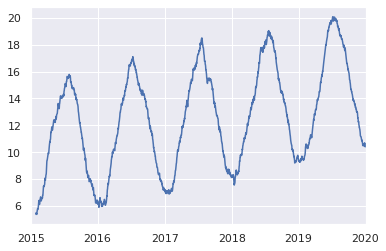

In [9]:
# Is there a trend? Let's plot a rolling average to see
df['y3'].rolling(30).mean().plot();

In this plot, we can see the long-term trend much more clearly.  And we can also already see a clear seasonal cycle and the fact that the nose appears to be on a much smaller time-scale than the seasonal cycle.  In fact, the monthly averaging sees to have mostly removed the impact of the noise.

Detrending a dataset like this can easily be accomplished by fitting it to a linear model of the form
```
y = ax + b
```
There are a number of function that can do this, including [numpy.polyfit()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html).

In [10]:
# Fit to a linear trend
df2 = df.reset_index() #This doesn't work for time indexes, so we need to reset
coeff = np.polyfit(df2.index,df2.y3,deg=1)

print('Slope (a): %f' % coeff[0])
print('Offset (b): %f' % coeff[1])

Slope (a): 0.002824
Offset (b): 9.915831


The polyfit function returns the coefficient to the equation above. The first element is the slope and the second is the mean.  

But remember, the slope is per day because our x-values are daily.  So let's calculate the annual change by multiplying by 365.

In [11]:
coeff[0]*365

1.030581968924065

From this, we see the increase is about 1 per year, which matches the trend we specified above of 5 over 5 years.

Now that we have a model for the trend, we can use it to back out the trend from our original dataset. 

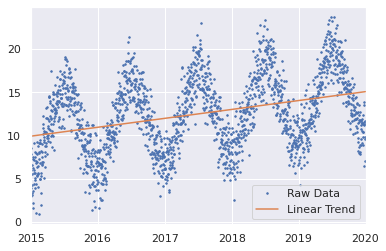

In [12]:
# Now let's remove the trend
model = np.poly1d(coeff)
df['trend'] = model(df2.index) # Remember, this model uses the the interger x axis, not time

df['y3'].plot(marker='.',linestyle='',markersize=3,label='Raw Data')
df['trend'].plot(label='Linear Trend');
plt.legend();

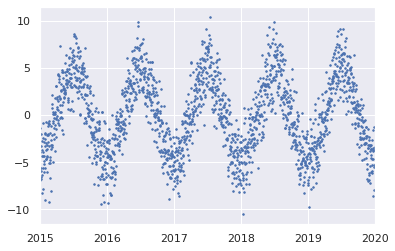

In [13]:
# Calculate and plot the residuals
df['residual'] = df['y3'] - df['trend']

df['residual'].plot(marker='.',linestyle='',markersize=3);

## 3. Modeling the Seasonal Cycle
There are a number of ways to model cyclic processes, like a seasonal cycle.  If you know the underlying process behind your data (like the harmonic tides which can be predicted using astronomical harmonics), it's always best to use that.  

But in our case, let's say we don't know what that process is, only that it repeats each year.  So, let's develop a simple seasonal model that has an expected value for each yearday (the day of the year from 1-365), which we will calculate based on the mean of each yearday from the 5-year dataset.

In [0]:
# Add a yearday column
df['yearday'] = df.index.dayofyear

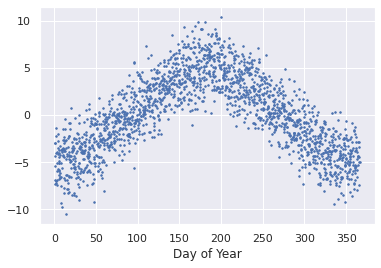

In [15]:
# Plot data by yearday
plt.plot(df.yearday,df.residual,'.',markersize=3);
plt.xlabel('Day of Year');

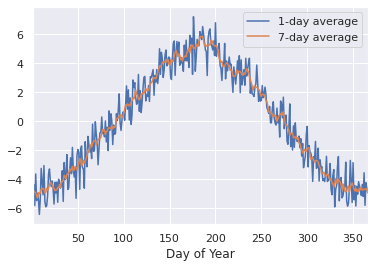

In [16]:
# Calculate seasonal cycles
yr = df.residual.groupby(df.yearday).mean()
yr.plot(label='1-day average')

yr7 = yr.rolling(7,center=True,min_periods=4).mean()
yr7.plot(label='7-day average')
plt.legend();
plt.xlabel('Day of Year');

Because we only have 5 values for each yearday (remember, we setup our dataset as daily data for 5-years), our model would be a bit noisy if we only used 1-day averages.  

In order to smooth our model a bit more, we will use the 7-day rolling average.

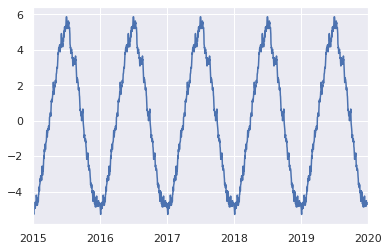

In [17]:
# Create and plot our seasonal prediction
df['seasonal'] = yr7[df.yearday].values
df['seasonal'].plot();

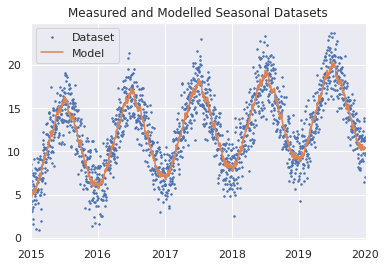

In [18]:
# Now let's compare our model to our original dataset
df['y3'].plot(label='Dataset',marker='.',linestyle='',markersize=3)
(df['trend'] + df['seasonal']).plot(label='Model')
plt.title('Measured and Modelled Seasonal Datasets')
plt.legend();
plt.savefig('Seasonal Model.png');

## 4. Looking at the residuals

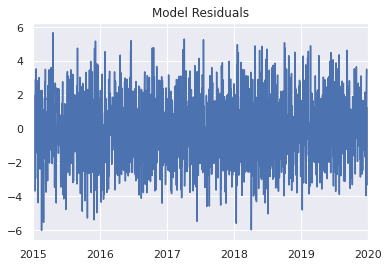

In [19]:
# Calculate the residuals from the full model (trend + seasonal cycle)
df['residual2'] = df['y3'] - df['trend'] - df['seasonal']

# Plot final residuals
df['residual2'].plot();
plt.title('Model Residuals');

From this plot, it looks like the residuals are a bit noisy, that is, there doesn't seem to be a discernible process beyond random noise (though there are many different kinds of random processes one could investigate), so our model looks like it might be a good fit.

If we look at the statistics of the noise...

In [20]:
df['residual2'].describe()

count    1827.000000
mean       -0.000248
std         1.971202
min        -6.015129
25%        -1.346109
50%         0.011878
75%         1.342863
max         5.671192
Name: residual2, dtype: float64

We note that the mean is very close to 0, and the standard deviation is very close to 2.  If you recall above, the random (that is to say, normally distributed) noise we added to our dataset used these values.

You can try modifying those values above to see if you get the same results here.  Of course, you are unlikely to get exactly the same values because our model isn't a perfect fit.  Calculating how good our fit (model) is, is a topic for another day.

Finally, let't take a look at the histogram of the residuals.

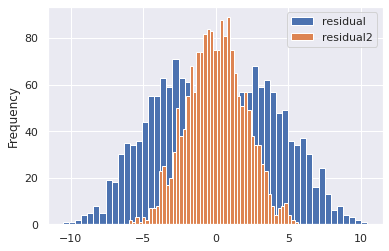

In [21]:
df['residual'].plot.hist(bins=50);
df['residual2'].plot.hist(bins=50);
plt.legend();

The blue lines, which show the residuals after the linear trend is removed but before the seasonal cycle was removed, does not appear to be normally distributed.

But it looks like the orange lines (the residuals after the trend and seasonal cycle was removed) looks a lot like a Gaussian curve.  

So for our final model, the variance looks to be normally distributed (that is to say Gaussian), as we would expect since that's how we set up our initial dataset.  

But it's important to note that the variance could have easily come from another possible distribution (e.g. Poisson, or Weibull), but we would have to run statistical tests to confirm this.

If we are able to identify the underlying distribution of the residuals, we might then be able to describe the underlying process that controls them.  

Ultimately, the variance in the residuals to our model could be from natural processes we haven't yet deciphered, or they could come from instrument error or sensitivity (or lack thereof).  

Figuring that out usually isn't easy, but that the fun of data analysis and oceanography.

## 5. Coda: Another approach from Facebook
As noted at the beginning, thanks to the boom in Data Science, there are now a number of timeseries analysis libraries available.  As an example, let's use the [Facebook Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api) tool to generate a model and make a prediction for the next year.

In [22]:
# Prophet requires a DataFrame with the colums ds and y
df2 = df['y3'].reset_index()
df2 = df2.rename(columns={'index':'ds', 'y3':'y'})
df2.head()

,ds,y
0,2015-01-01,2.987085
1,2015-01-02,8.500298
2,2015-01-03,6.034994
3,2015-01-04,7.885226
4,2015-01-05,3.973079


In [23]:
# Model setup, using the default settings
from fbprophet import Prophet
m = Prophet()
m.fit(df2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
# Create a time series that goes 1-year into the future
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
2187,2020-12-27
2188,2020-12-28
2189,2020-12-29
2190,2020-12-30
2191,2020-12-31


In [25]:
# Make the prediction
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2187,2020-12-27,11.333876,8.791986,13.802309
2188,2020-12-28,11.642139,9.316436,14.391309
2189,2020-12-29,11.459850,8.955795,13.983196
2190,2020-12-30,11.450388,8.846067,13.865701
2191,2020-12-31,11.774763,9.174101,14.409361


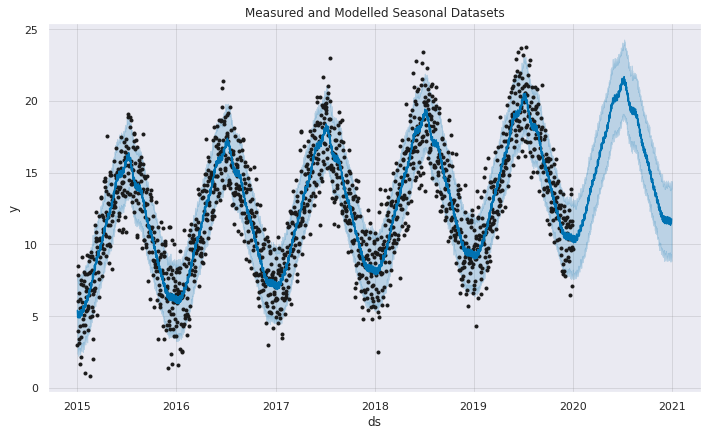

In [26]:
# Plot the model fit and forecast
fig1 = m.plot(forecast)
plt.title('Measured and Modelled Seasonal Datasets');
plt.savefig('Seasonal Model2.png')

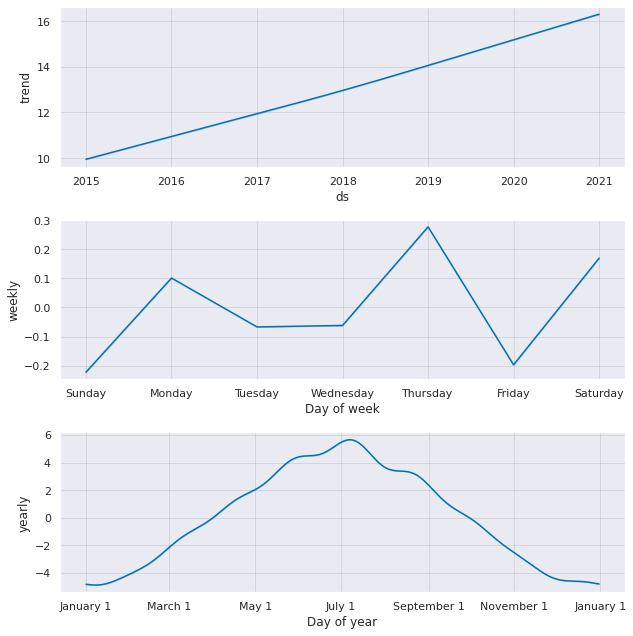

In [27]:
# Plot the model components
fig2 = m.plot_components(forecast)